In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.tools.config import *
from taiko.play import get_play, get_similarity
from taiko.database import load_record_df

from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
import multiprocessing
from sklearn.preprocessing import StandardScaler

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
SONG_ID = 1

In [4]:
record_df = load_record_df(song_id=SONG_ID)
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
13,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23
25,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16
29,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10
33,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26
37,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11
42,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21
46,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57


In [5]:
play_result_df = pd.read_csv(PLAY_RESULT_TABLE_PATH)
play_result_df.drop(['drummer_name', 'song_id', 'capture_datetime'], axis=1, inplace=True)
play_record_df = record_df.merge(play_result_df, left_index=True, right_on='id', how='inner')
play_record_df['note'] = play_record_df['good'] + play_record_df['ok'] + play_record_df['bad']
play_record_df = play_record_df[play_record_df['note'] == ALL_NOTE_COUNT_DICT[SONG_ID]]
play_record_df.drop('note', axis=1, inplace=True)
play_record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
16,carolyn,1,L_2018-09-27_154913.csv,R_2018-09-27_154916.csv,capture_2018_09_27_15_49_16,25,1,792630,54,30,2,84,42
20,carolyn,1,L_2018-09-27_160509.csv,R_2018-09-27_160510.csv,capture_2018_09_27_16_05_10,29,2,803450,57,25,4,61,48
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95


In [6]:
full_combo_df = play_record_df[play_record_df['bad'] == 0]
full_combo_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
4,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13,5,2,989360,84,2,0,86,63
8,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41,9,3,979660,84,2,0,86,68
12,aaaaa,1,L_2018-09-28_115822.csv,R_2018-09-28_115823.csv,capture_2018_09_28_11_58_23,13,4,991060,84,2,0,86,74
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
28,carolyn,1,L_2018-09-27_163110.csv,R_2018-09-27_163111.csv,capture_2018_09_27_16_31_11,37,4,913960,71,15,0,86,47
32,celiven,1,L_2018-09-22_141822.csv,R_2018-09-22_141821.csv,capture_2018_09_22_14_18_21,42,1,978860,82,4,0,86,94
35,celiven,1,L_2018-09-22_142958.csv,R_2018-09-22_142957.csv,capture_2018_09_22_14_29_57,46,2,994710,85,1,0,86,95
38,celiven,1,L_2018-09-22_144040.csv,R_2018-09-22_144039.csv,capture_2018_09_22_14_40_39,50,3,989460,84,2,0,86,94
40,celiven,1,L_2018-09-22_145139.csv,R_2018-09-22_145139.csv,capture_2018_09_22_14_51_38,54,4,999560,86,0,0,86,50


In [7]:
# test
# CONSIDERED_IDS = [61, 150]

# doraemon individual
CONSIDERED_IDS = [1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

# doraemon individual for two occurance
# CONSIDERED_IDS = [1, 5, 33, 37, 61, 65, 99, 107, 141, 150, 180, 181, 241, 249, 254, 258, 288, 310, 323, 327]

# RPG individual for two occurance
# CONSIDERED_IDS = [10, 14, 52, 56, 79, 83, 121, 125, 155, 159, 208, 216, 280, 284, 311, 315, 350, 354]

# all
# CONSIDERED_IDS = play_record_df['id'].values

# full combo
# CONSIDERED_IDS = full_combo_df['id'].values

CONSIDERED_IDS

[1, 33, 61, 99, 150, 180, 241, 254, 288, 323]

In [8]:
plays = []
with multiprocessing.Pool() as p:
    for _, play in tqdm(enumerate(p.imap(get_play, CONSIDERED_IDS)), total=len(CONSIDERED_IDS)):
        plays.append(play)
        
play_record_df[play_record_df['id'].isin(CONSIDERED_IDS)]

100%|██████████| 10/10 [00:23<00:00, 11.41s/it]


,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime,id,p_order,score,good,ok,bad,max_combo,drumroll
0,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05,1,1,975110,81,5,0,86,78
24,carolyn,1,L_2018-09-27_161825.csv,R_2018-09-27_161826.csv,capture_2018_09_27_16_18_26,33,3,945560,76,10,0,86,49
45,chris,1,L_2018-09-26_133059.csv,R_2018-09-26_133100.csv,capture_2018_09_26_13_30_59,61,1,908230,76,10,0,86,44
81,cuxi,1,L_2018-09-25_160510.csv,R_2018-09-25_160512.csv,capture_2018_09_25_16_05_13,99,2,942410,77,9,0,86,63
129,eve,1,L_2018-09-28_163325.csv,R_2018-09-28_163326.csv,capture_2018_09_28_16_33_26,150,6,928410,75,11,0,86,38
158,howeverover,1,L_2018-09-21_121510.csv,R_2018-09-21_121511.csv,capture_2018_09_21_12_15_11,180,2,978060,82,4,0,86,57
210,john,1,L_2018-09-28_205220.csv,R_2018-09-28_205221.csv,capture_2018_09_28_20_52_21,241,6,851960,61,25,0,86,57
222,kdchang,1,L_2018-09-25_212428.csv,R_2018-09-25_212429.csv,capture_2018_09_25_21_24_30,254,1,673990,35,51,0,86,59
254,oliver,1,L_2018-09-26_184134.csv,R_2018-09-26_184135.csv,capture_2018_09_26_18_41_34,288,1,946460,78,8,0,86,57
287,sheep,1,L_2018-09-27_110739.csv,R_2018-09-27_110741.csv,capture_2018_09_27_11_07_41,323,1,962510,81,5,0,86,56


In [9]:
HANDS = ['L', 'R']
_K = 370
SIMILARITY_COLUMNS = [a + '_' + b for a, b in product(HANDS, ZERO_ADJ_COL)]
SIMILARITY_COLUMNS = [str(k) + '_' + b for k, b in product(range(_K), SIMILARITY_COLUMNS)]
SIMILARITY_COLUMNS

['0_L_imu_ax',
 '0_L_imu_ay',
 '0_L_imu_az',
 '0_L_imu_gx',
 '0_L_imu_gy',
 '0_L_imu_gz',
 '0_R_imu_ax',
 '0_R_imu_ay',
 '0_R_imu_az',
 '0_R_imu_gx',
 '0_R_imu_gy',
 '0_R_imu_gz',
 '1_L_imu_ax',
 '1_L_imu_ay',
 '1_L_imu_az',
 '1_L_imu_gx',
 '1_L_imu_gy',
 '1_L_imu_gz',
 '1_R_imu_ax',
 '1_R_imu_ay',
 '1_R_imu_az',
 '1_R_imu_gx',
 '1_R_imu_gy',
 '1_R_imu_gz',
 '2_L_imu_ax',
 '2_L_imu_ay',
 '2_L_imu_az',
 '2_L_imu_gx',
 '2_L_imu_gy',
 '2_L_imu_gz',
 '2_R_imu_ax',
 '2_R_imu_ay',
 '2_R_imu_az',
 '2_R_imu_gx',
 '2_R_imu_gy',
 '2_R_imu_gz',
 '3_L_imu_ax',
 '3_L_imu_ay',
 '3_L_imu_az',
 '3_L_imu_gx',
 '3_L_imu_gy',
 '3_L_imu_gz',
 '3_R_imu_ax',
 '3_R_imu_ay',
 '3_R_imu_az',
 '3_R_imu_gx',
 '3_R_imu_gy',
 '3_R_imu_gz',
 '4_L_imu_ax',
 '4_L_imu_ay',
 '4_L_imu_az',
 '4_L_imu_gx',
 '4_L_imu_gy',
 '4_L_imu_gz',
 '4_R_imu_ax',
 '4_R_imu_ay',
 '4_R_imu_az',
 '4_R_imu_gx',
 '4_R_imu_gy',
 '4_R_imu_gz',
 '5_L_imu_ax',
 '5_L_imu_ay',
 '5_L_imu_az',
 '5_L_imu_gx',
 '5_L_imu_gy',
 '5_L_imu_gz',
 '5_R_imu_

In [10]:
similarity_mat = []
with multiprocessing.Pool() as p:
    result = p.starmap(get_similarity, product(plays, repeat=2))
    ids = list(product(CONSIDERED_IDS, repeat=2))
    for ids_, sim in zip(ids, result):
        similarity_mat.append(list(ids_) + list(sim))
#         sim = get_similarity(row1[1], row2[1])
#         similarity_mat.append([row1[0], row2[0], sim[0], sim[1]])
#         print(sim)

similarity_df = pd.DataFrame(data=similarity_mat)
similarity_df.columns = ['a_id', 'b_id'] + SIMILARITY_COLUMNS
similarity_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_az,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz
0,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,33,10.169589,11.184191,4.777461,124.699450,161.459841,96.109019,3.205315,12.089189,...,17.897770,17.998164,32.330166,27.927642,1.387638,8.263089,18.442148,15.603448,78.247844,32.000161
2,1,61,3.491989,7.699344,10.632944,113.045052,122.863664,48.242037,3.191351,1.427246,...,21.513673,64.766903,65.440517,74.381256,3.069283,2.467802,21.354689,40.353078,59.816095,54.803634
3,1,99,5.522518,8.024690,4.544273,131.437856,103.411914,32.025740,9.149560,5.691698,...,63.539540,133.074662,34.853633,34.491937,7.612598,18.558740,62.594280,122.454367,41.438765,65.092255
4,1,150,10.527203,14.191264,6.924996,295.387051,141.422106,593.959389,10.590508,34.315195,...,23.429299,19.080087,28.867267,16.566838,1.787197,5.841005,23.205719,23.886775,44.463547,43.211122
5,1,180,5.403516,5.194404,3.558999,64.694708,98.818342,16.381881,5.083491,5.737947,...,21.952119,37.785660,73.536298,101.594489,13.081195,23.495301,30.487671,456.851113,233.702177,287.001267
6,1,241,3.143146,5.885643,2.337192,102.965810,117.728022,15.918585,2.925854,5.890529,...,26.198230,43.601600,92.098616,149.430501,2.360449,3.752043,28.095992,71.200975,37.178065,95.868575
7,1,254,2.714596,8.926927,8.303981,69.235258,107.871301,19.095921,3.302751,8.365580,...,14.491167,86.120839,86.724813,64.300105,4.786084,8.306203,15.521225,95.939160,108.227807,85.369376
8,1,288,6.535088,4.959281,8.506685,288.740539,140.901267,173.839169,7.472518,3.190754,...,26.972335,22.228637,26.371124,15.695059,0.893816,5.051798,26.767422,26.711894,36.976054,18.637052
9,1,323,5.270935,2.234667,2.062114,139.702190,148.916014,71.277912,5.007331,5.206423,...,28.724892,49.050721,60.980044,20.018646,3.535685,12.698607,28.682725,53.719743,49.520141,30.680644


In [11]:
dtw_df = similarity_df.copy()
dtw_df['same'] = (dtw_df['a_id'] == dtw_df['b_id'])
dtw_df = dtw_df[~dtw_df['same']].drop('same', axis=1)
# for col in SIMILARITY_COLUMNS:
#     sns.distplot(dtw_df[col])
#     plt.show()

In [12]:
scaler = StandardScaler()
dtw_df[SIMILARITY_COLUMNS] = scaler.fit_transform(dtw_df[SIMILARITY_COLUMNS])
# dtw_df['acc_dtw'] -= dtw_df.min(axis=0)['acc_dtw']
# dtw_df['gyr_dtw'] -= dtw_df.min(axis=0)['gyr_dtw']
dtw_df['norm_sim'] = dtw_df[SIMILARITY_COLUMNS].mean(axis=1)
dtw_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,norm_sim
1,1,33,1.742702,0.251593,-0.712210,-0.315030,1.921445,-0.436632,-0.946919,-0.091662,...,-1.000235,-0.908678,-0.969495,-1.150167,-0.623532,0.093915,-0.821964,-0.302365,-0.925953,-0.040052
2,1,61,-0.774748,-0.343712,1.404084,-0.441306,0.855343,-0.658478,-0.950799,-0.999183,...,-0.000166,-0.060685,-0.023596,-0.725702,-1.292353,0.293533,-0.673292,-0.574439,-0.680503,-0.067518
3,1,99,-0.009240,-0.288134,-0.796489,-0.242018,0.318047,-0.733634,0.704401,-0.636203,...,1.460478,-0.844049,-0.835832,0.421079,0.564665,3.119982,-0.180109,-0.845709,-0.569760,0.108312
4,1,150,1.877522,0.765281,0.063954,1.534382,1.367963,1.870726,1.104699,1.800166,...,-0.977100,-0.997366,-1.200827,-1.049314,-0.903059,0.420397,-0.772206,-0.801060,-0.805282,0.083958
5,1,180,-0.054103,-0.771622,-1.152587,-0.965185,0.191164,-0.806138,-0.425159,-0.632266,...,-0.577114,0.146657,0.530526,1.801411,1.134382,0.919483,1.828614,1.992316,1.818803,0.641157
6,1,241,-0.906261,-0.653540,-1.594174,-0.550515,0.713486,-0.808285,-1.024554,-0.619279,...,-0.452750,0.622059,1.504575,-0.904619,-1.144142,0.755563,-0.487989,-0.908601,-0.238493,0.311474
7,1,254,-1.067824,-0.134008,0.562348,-0.915988,0.441224,-0.793560,-0.919852,-0.408608,...,0.456451,0.484430,-0.228871,-0.292363,-0.618556,-0.106277,-0.339386,0.140173,-0.351503,0.074290
8,1,288,0.372498,-0.811787,0.635610,1.462367,1.353577,-0.076380,0.238517,-0.849077,...,-0.909774,-1.061295,-1.218578,-1.274813,-0.994140,0.664507,-0.755235,-0.911583,-1.069790,0.326329
9,1,323,-0.104087,-1.277224,-1.693593,-0.152474,1.574960,-0.551715,-0.446316,-0.677508,...,-0.336230,-0.174923,-1.130540,-0.607977,-0.111639,0.795776,-0.592999,-0.726419,-0.940156,0.901238
10,33,1,1.742702,0.251593,-0.712210,-0.315030,1.921445,-0.436632,-0.946919,-0.091662,...,-1.000235,-0.908678,-0.969495,-1.150167,-0.623532,0.093915,-0.821964,-0.302365,-0.925953,-0.040052


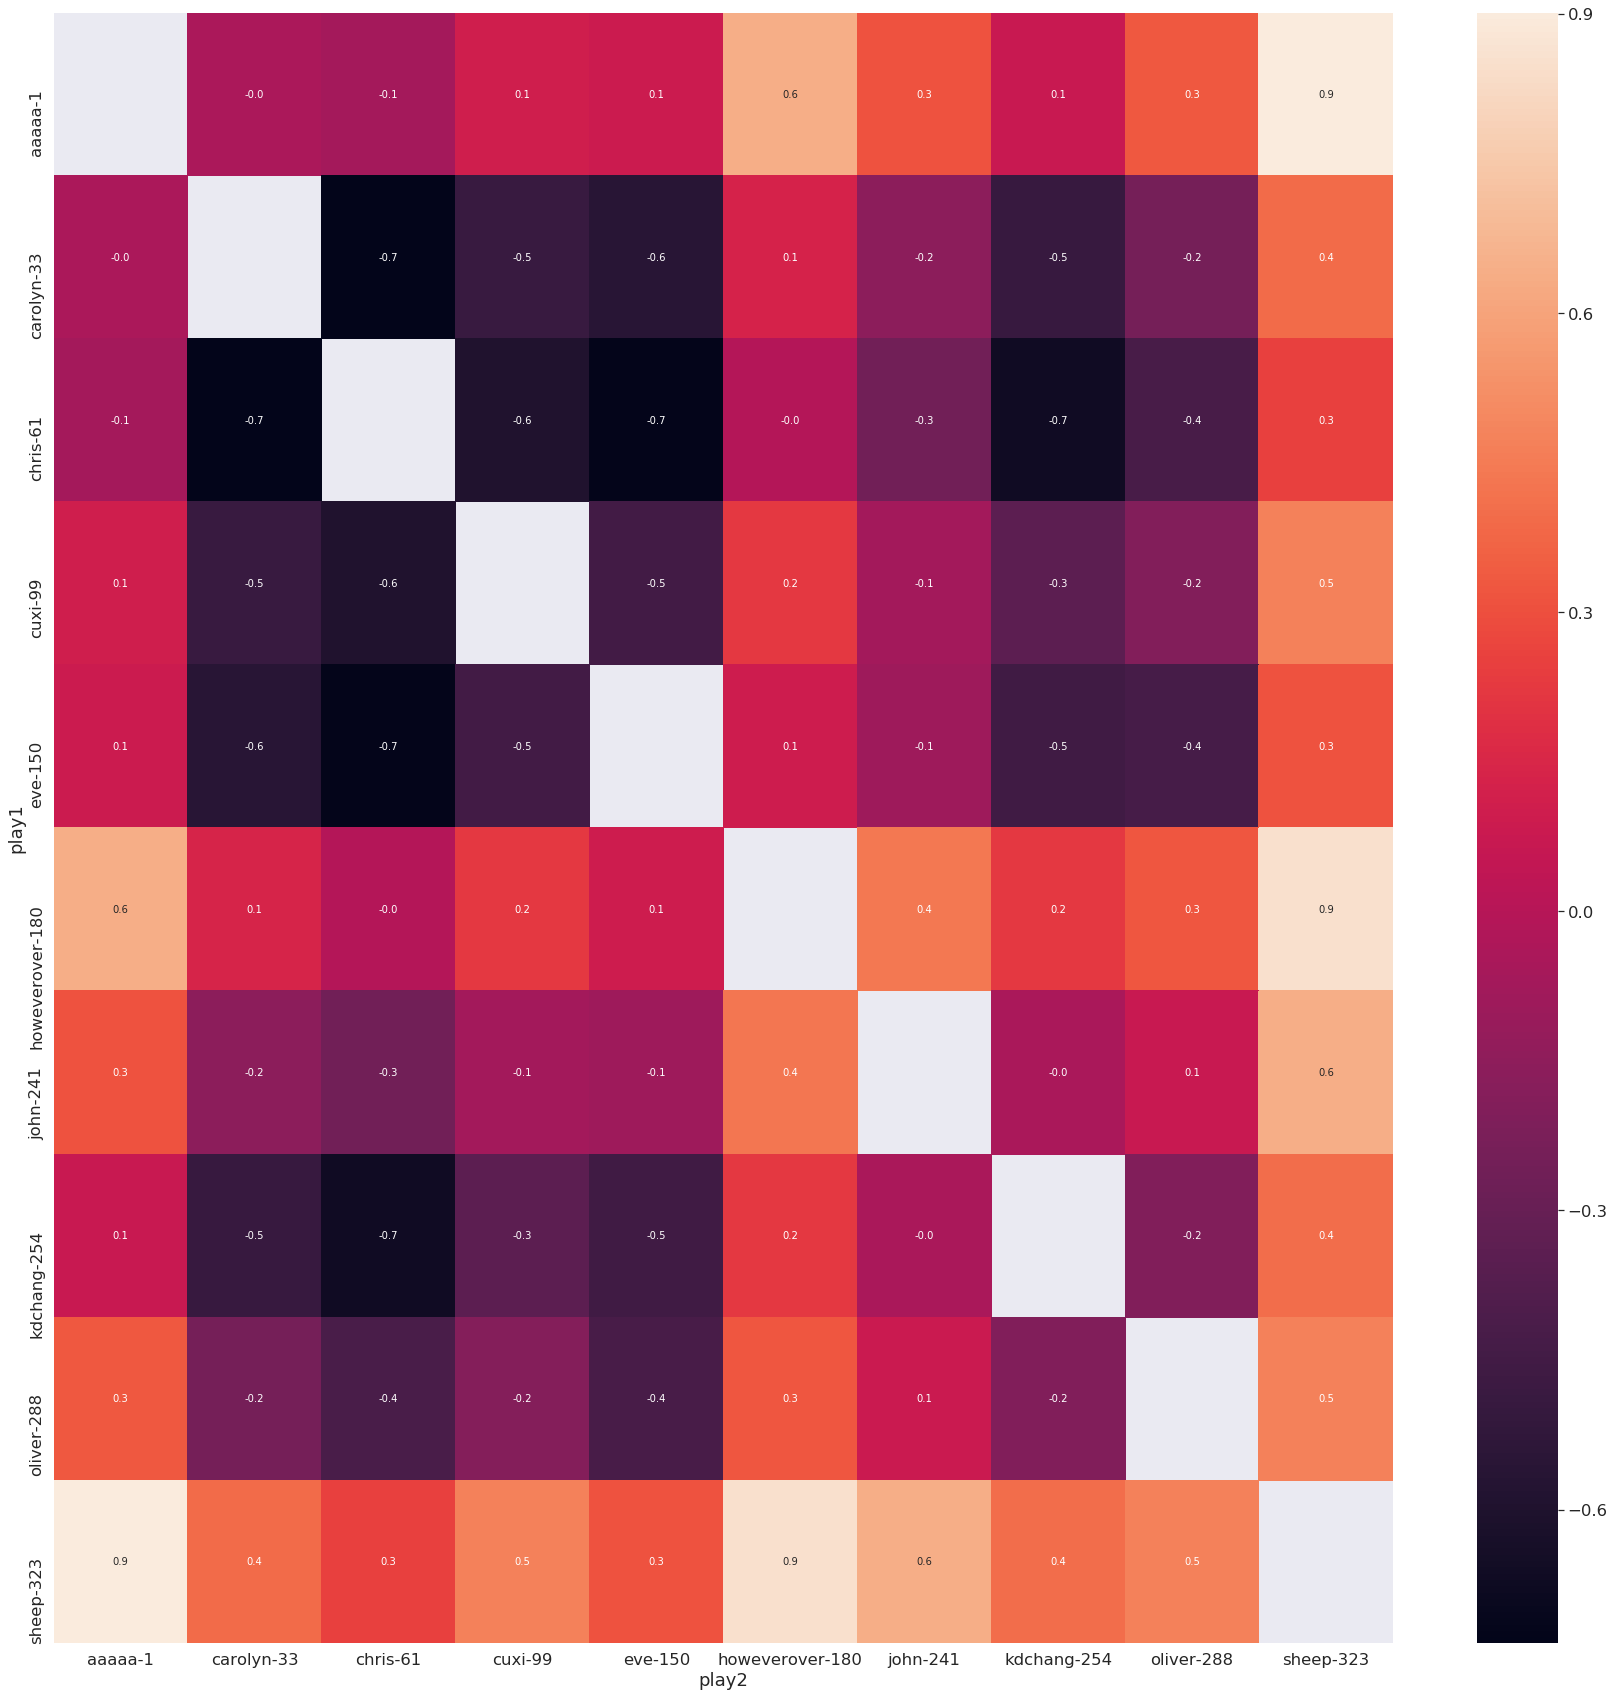

In [13]:
vis_right_df = play_record_df.copy()
vis_right_df = vis_right_df[['drummer_name', 'id']]

vis_df = dtw_df.merge(vis_right_df, left_on='a_id', right_on='id', how='inner')
vis_df = vis_df.merge(vis_right_df, left_on='b_id', right_on='id', how='inner')
vis_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
vis_df = vis_df.rename(index=str, columns={'drummer_name_x': 'a_drummer_name',
                                  'drummer_name_y': 'b_drummer_name'})
vis_df['a_id'] = vis_df['a_id'].apply(str)
vis_df['b_id'] = vis_df['b_id'].apply(str)
vis_df['play1'] = vis_df[['a_drummer_name', 'a_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df['play2'] = vis_df[['b_drummer_name', 'b_id']].apply(lambda x: '-'.join(x), axis=1)
vis_df = vis_df.pivot('play1', 'play2', 'norm_sim')
plt.figure(figsize=(30, 30))
ax = sns.heatmap(vis_df, annot=True, fmt='.1f')

# LGBM

In [14]:
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
score_right_df = play_record_df.copy()
score_right_df = score_right_df[['score', 'id']]

score_df = dtw_df.copy()
score_df = score_df.merge(score_right_df, left_on='a_id', right_on='id', how='inner')
score_df = score_df.merge(score_right_df, left_on='b_id', right_on='id', how='inner')
score_df = score_df[score_df['a_id'] < score_df['b_id']]
score_df.drop(['id_x', 'id_y'], axis=1, inplace=True)
score_df['score_dif'] = np.abs(score_df['score_x'] - score_df['score_y'])
score_df.drop(['score_x', 'score_y'], axis=1, inplace=True)
score_df

,a_id,b_id,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,...,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,norm_sim,score_dif
0,1,33,1.742702,0.251593,-0.712210,-0.315030,1.921445,-0.436632,-0.946919,-0.091662,...,-0.908678,-0.969495,-1.150167,-0.623532,0.093915,-0.821964,-0.302365,-0.925953,-0.040052,29550
9,1,61,-0.774748,-0.343712,1.404084,-0.441306,0.855343,-0.658478,-0.950799,-0.999183,...,-0.060685,-0.023596,-0.725702,-1.292353,0.293533,-0.673292,-0.574439,-0.680503,-0.067518,66880
10,33,61,1.060554,1.332138,1.208018,-1.111578,-0.328355,-0.494402,-1.207894,0.002024,...,0.082296,0.048262,-0.564585,-0.602471,-0.962671,-0.754915,-0.377933,-0.673218,-0.734127,37330
18,1,99,-0.009240,-0.288134,-0.796489,-0.242018,0.318047,-0.733634,0.704401,-0.636203,...,-0.844049,-0.835832,0.421079,0.564665,3.119982,-0.180109,-0.845709,-0.569760,0.108312,32700
19,33,99,1.366026,1.540304,-0.524659,0.699987,0.430310,-0.456475,0.549358,0.359194,...,-1.165131,-0.568105,0.569161,1.511524,1.856639,-0.268231,-0.778389,-0.292207,-0.485011,3150
20,61,99,-0.990483,-1.099640,0.272300,0.769960,-0.540799,-0.708476,0.659806,-0.713814,...,0.155016,0.524610,0.026751,0.578504,1.659179,-0.363959,-0.672221,-0.134450,-0.597248,34180
27,1,150,1.877522,0.765281,0.063954,1.534382,1.367963,1.870726,1.104699,1.800166,...,-0.997366,-1.200827,-1.049314,-0.903059,0.420397,-0.772206,-0.801060,-0.805282,0.083958,46700
28,33,150,1.151988,2.453609,0.822743,0.547631,1.699929,2.019022,0.928689,2.813309,...,-1.634884,-1.086786,-0.770058,-1.289609,-0.827475,-0.839246,-0.254229,-0.760425,-0.556431,17150
29,61,150,1.091943,0.768541,2.038665,0.362226,0.499239,2.060770,1.358583,1.702978,...,0.058281,0.188071,-0.834320,-0.878000,-0.988912,-0.774930,-0.232628,-0.318282,-0.727547,20180
30,99,150,1.299254,0.424903,0.351923,2.749492,0.928075,1.954011,2.236950,1.372866,...,-1.171508,-0.988039,0.240849,1.227316,1.535458,-0.302018,-0.488327,-0.333672,-0.451727,14000


In [16]:
train_df = score_df.drop(['a_id', 'b_id', 'norm_sim'], axis=1).copy()
x = train_df.drop('score_dif', axis=1)
y = train_df['score_dif']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, random_state=0, test_size=0.5)

train_df

,0_L_imu_ax,0_L_imu_ay,0_L_imu_az,0_L_imu_gx,0_L_imu_gy,0_L_imu_gz,0_R_imu_ax,0_R_imu_ay,0_R_imu_az,0_R_imu_gx,...,369_L_imu_gx,369_L_imu_gy,369_L_imu_gz,369_R_imu_ax,369_R_imu_ay,369_R_imu_az,369_R_imu_gx,369_R_imu_gy,369_R_imu_gz,score_dif
0,1.742702,0.251593,-0.712210,-0.315030,1.921445,-0.436632,-0.946919,-0.091662,-0.827326,-0.768461,...,-1.000235,-0.908678,-0.969495,-1.150167,-0.623532,0.093915,-0.821964,-0.302365,-0.925953,29550
9,-0.774748,-0.343712,1.404084,-0.441306,0.855343,-0.658478,-0.950799,-0.999183,0.059269,-0.730650,...,-0.000166,-0.060685,-0.023596,-0.725702,-1.292353,0.293533,-0.673292,-0.574439,-0.680503,66880
10,1.060554,1.332138,1.208018,-1.111578,-0.328355,-0.494402,-1.207894,0.002024,0.782847,-0.922116,...,-0.226207,0.082296,0.048262,-0.564585,-0.602471,-0.962671,-0.754915,-0.377933,-0.673218,37330
18,-0.009240,-0.288134,-0.796489,-0.242018,0.318047,-0.733634,0.704401,-0.636203,-0.706109,-0.307597,...,1.460478,-0.844049,-0.835832,0.421079,0.564665,3.119982,-0.180109,-0.845709,-0.569760,32700
19,1.366026,1.540304,-0.524659,0.699987,0.430310,-0.456475,0.549358,0.359194,-0.396720,-0.133276,...,1.077615,-1.165131,-0.568105,0.569161,1.511524,1.856639,-0.268231,-0.778389,-0.292207,3150
20,-0.990483,-1.099640,0.272300,0.769960,-0.540799,-0.708476,0.659806,-0.713814,-0.123243,-0.147992,...,0.722974,0.155016,0.524610,0.026751,0.578504,1.659179,-0.363959,-0.672221,-0.134450,34180
27,1.877522,0.765281,0.063954,1.534382,1.367963,1.870726,1.104699,1.800166,1.775209,1.974132,...,-0.977100,-0.997366,-1.200827,-1.049314,-0.903059,0.420397,-0.772206,-0.801060,-0.805282,46700
28,1.151988,2.453609,0.822743,0.547631,1.699929,2.019022,0.928689,2.813309,2.486034,1.827341,...,-1.331840,-1.634884,-1.086786,-0.770058,-1.289609,-0.827475,-0.839246,-0.254229,-0.760425,17150
29,1.091943,0.768541,2.038665,0.362226,0.499239,2.060770,1.358583,1.702978,0.243817,1.840345,...,-0.239581,0.058281,0.188071,-0.834320,-0.878000,-0.988912,-0.774930,-0.232628,-0.318282,20180
30,1.299254,0.424903,0.351923,2.749492,0.928075,1.954011,2.236950,1.372866,1.536882,2.526376,...,1.055956,-1.171508,-0.988039,0.240849,1.227316,1.535458,-0.302018,-0.488327,-0.333672,14000


In [17]:
train_set = lgb.Dataset(x_train, y_train)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'application': 'rmse',
#     'min_data_in_leaf': 3,
#     'max_depth': 4,
#     'num_leaves': 2 ** 6,
    'verbosity': 0,
#     'metric': 'rmse'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

model = lgb.train(params, train_set=train_set, valid_sets=watchlist,
                  num_boost_round=500, verbose_eval=10, early_stopping_rounds=20)
y_pred = model.predict(x_test, num_iteration=model.best_iteration)

LightGBMError: Cannot construct Dataset since there are no useful features.
It should be at least two unique rows.
If the num_row (num_data) is small, you can set min_data=1 and min_data_in_bin=1 to fix this.
Otherwise, please make sure you are using the right dataset

In [ ]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'score_dif'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

plot_df = plot_df.head(50)
plt.figure(figsize=(8, 25))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)